# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


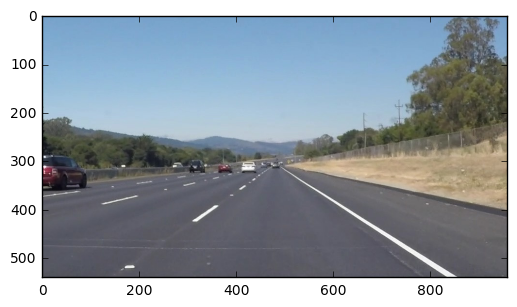

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [8]:
import os
imgs = os.listdir("test_images/")

run your solution on all test_images and make copies into the test_images directory).

In [9]:
'''params definitions'''
im_w = image.shape[1]
im_h = image.shape[0]

#  define roi
im_wb = 50  # pixels away the vertical half
im_hb = 60  # pixels below the horizontal half
btm = 20    # pixels the away the lower left/right 
vertices = np.array([[(im_w//2 - im_wb, im_h//2 + im_hb),
                      (im_w//2 + im_wb, im_h//2 + im_hb),
                      (im_w - btm, im_h),
                      (btm, im_h)]])



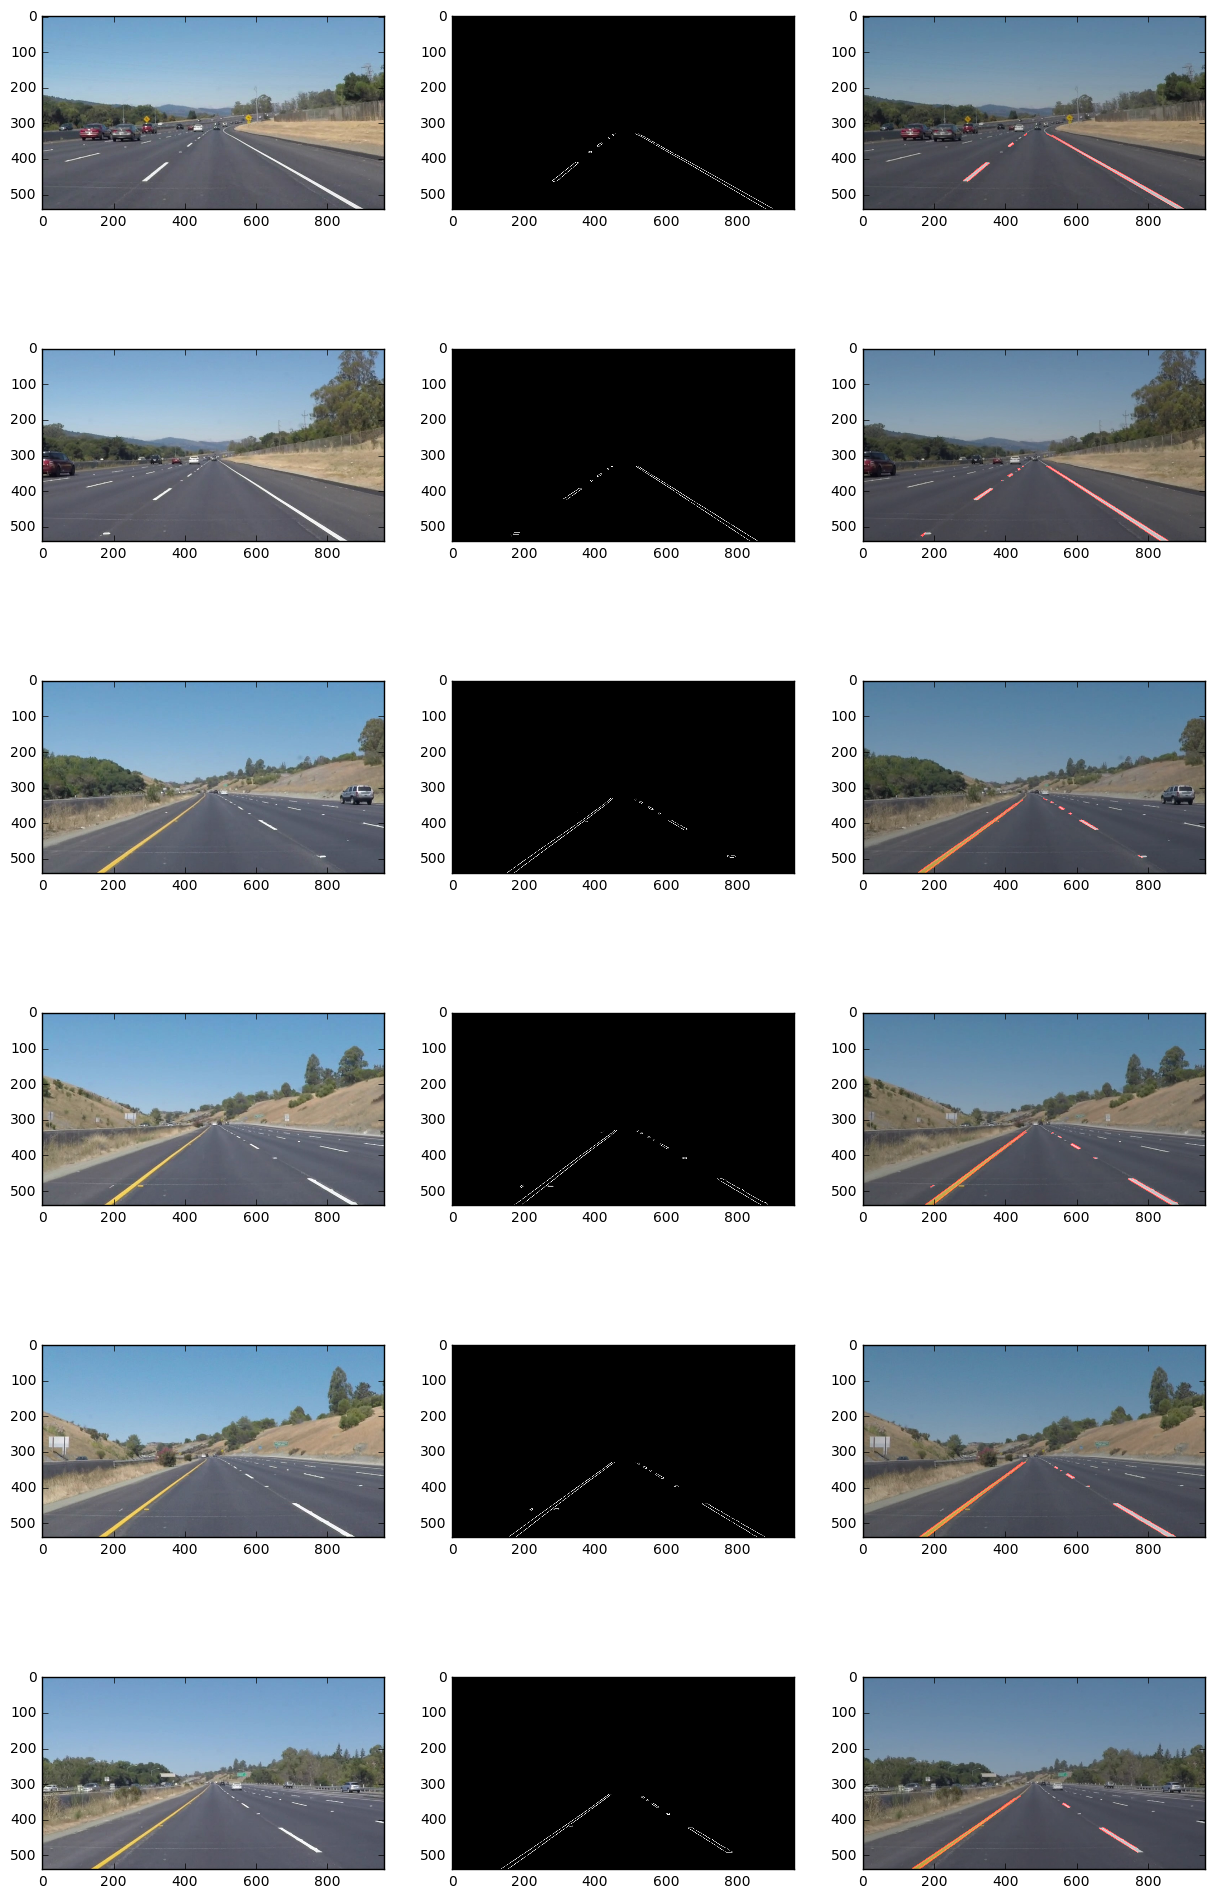

In [10]:
'''free hand test'''
num = len(imgs)
fig = plt.figure(figsize = (15, 25))
for i in range(num):
    img = mpimg.imread(os.path.join('test_images/', imgs[i]))
    ax = fig.add_subplot(num, 3, 3 * i + 1)
    ax.imshow(img)
    
    gray = grayscale(img)                                                       
    noise = gaussian_blur(gray, 7)  

    edges = canny(noise, 90, 100)   
    
    roi = region_of_interest(edges, [vertices])          
    ax = fig.add_subplot(num, 3, 3 * i + 2)                        
    ax.imshow(roi, cmap = 'gray')

    lines = hough_lines(roi,1,np.pi/180,20,1,5)  
    result = weighted_img(lines, img)                     
    ax = fig.add_subplot(num, 3, 3 * i + 3)
    ax.imshow(result)

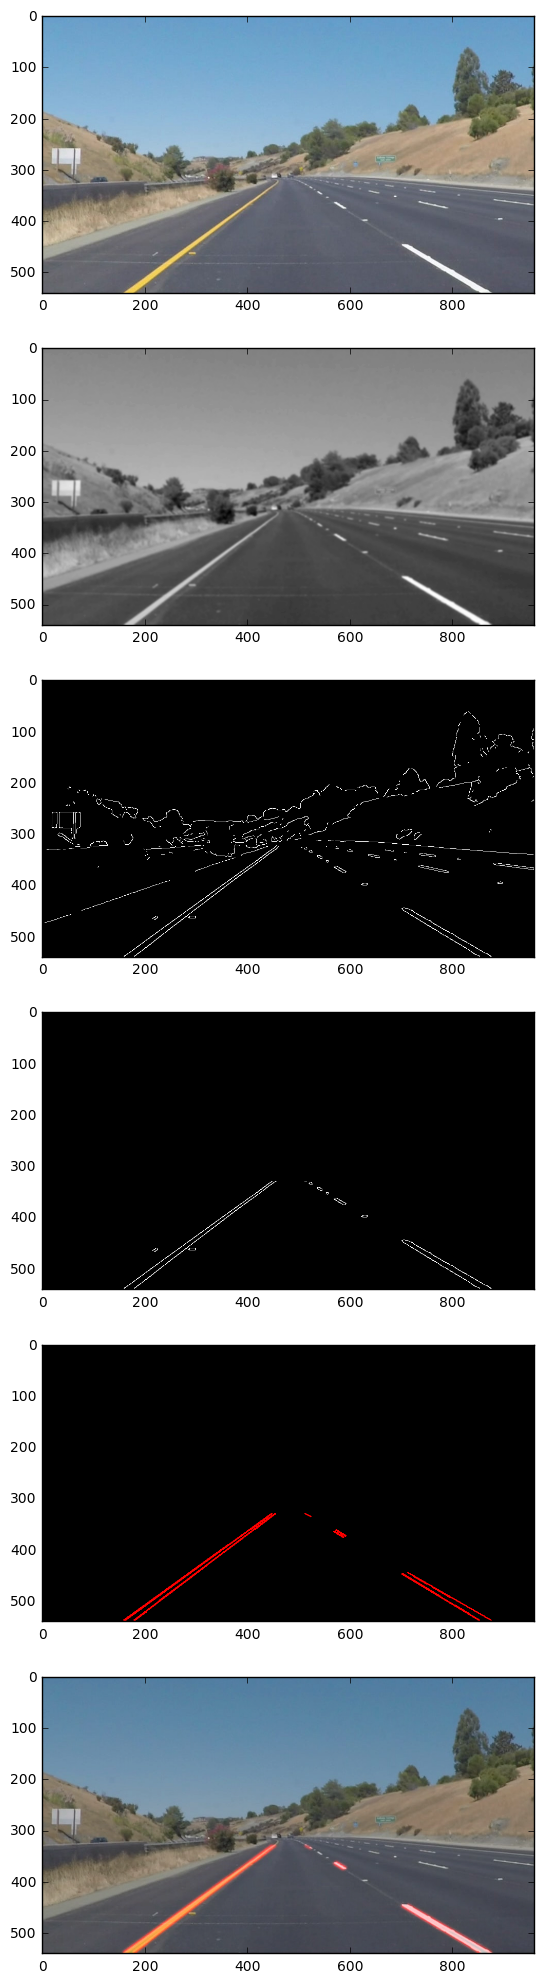

In [11]:
''' improve robustness by tuning a single imgs '''
fig = fig = plt.figure(figsize = (15,25))
im = mpimg.imread(os.path.join('test_images/', imgs[-2]))
ax = fig.add_subplot(6, 1, 1)
ax.imshow(im)

gray = grayscale(im)                                                       
noise = gaussian_blur(gray, 7)                      
ax = fig.add_subplot(6, 1, 2)                        
ax.imshow(noise, cmap = 'gray')

edges = canny(noise, 90, 100)                        
ax = fig.add_subplot(6, 1, 3)                        
ax.imshow(edges, cmap = 'gray')

roi = region_of_interest(edges, [vertices])          
ax = fig.add_subplot(6, 1, 4)                        
ax.imshow(roi, cmap = 'gray')

lines = hough_lines(roi,1,np.pi/180,20,10,5)    
ax = fig.add_subplot(6, 1, 5)                        
ax.imshow(lines, cmap = 'gray')

result = weighted_img(gaussian_blur(lines,13), im)                     
ax = fig.add_subplot(6, 1, 6)
ax.imshow(result)




## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [12]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [13]:


def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    gray = grayscale(image)                                                       
    noise = gaussian_blur(gray, 7)  
    edges = canny(noise, 90, 100)       
    roi = region_of_interest(edges, [vertices])    
    lines = hough_lines(roi,1,np.pi/180,10,10,5) 
    result = weighted_img(lines, image)           
    return result

   
    

In [14]:
for i in range(num):
    img = mpimg.imread(os.path.join('test_images/', imgs[i]))
    copy = os.path.join('test_images/', '%s_copy'%imgs[i])
    mpimg.imsave(copy, process_image(img), format='png') 

Let's try the one with the solid white lane on the right first ...

In [15]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:15<00:00, 12.54it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 43.5 s, sys: 1.54 s, total: 45 s
Wall time: 16.8 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

In [17]:
def ext_x(line, base):
    '''x_cordinate of the intersection of the line and a horizontal base'''
    x1, y1, x2, y2 = line
    return int(x1 + (x1-x2)/(y1-y2) * (base-y1))

class line_detector:
    def __init__(self):
        self.pre_x = None
        
    def draw_lines(self, img, lines, color=[255, 0, 0], thickness=7):
        '''a modified version of lines drawing'''
        mid = im_w/2
        max_len_l = [0, 0];  max_len_r = [0, 0]
        max_line_l = [[0,0,0,1e-6],[0,0,0,1e-6]];  max_line_r = [[0,0,0,1e-6],[0,0,0,1e-6]]

        # find top two lines according to length of both sides
        for line in lines:
            for x1, y1, x2, y2 in line:
                lth = (x1-x2)**2 + (y1-y2)**2
                if min(x1, x2) < mid:
                    if max_len_l[0] < lth:
                        max_len_l[0] = lth
                        max_line_l[0] = line[0]
                    elif max_len_l[1] < lth:
                        max_len_l[1] = lth
                        max_line_l[1] = line[0]
                elif max(x1, x2) > mid:
                    if max_len_r[0] < lth:
                        max_len_r[0] = lth
                        max_line_r[0] = line[0]
                    elif max_len_r[1] < lth:
                        max_len_r[1] = lth
                        max_line_r[1] = line[0]

        # extend the two lines and take avg    
        ext_x1_l = (ext_x(max_line_l[0], 540)+ext_x(max_line_l[1], 540))//2
        ext_x2_l = (ext_x(max_line_l[0], 330)+ext_x(max_line_l[1], 330))//2
        ext_x1_r = (ext_x(max_line_r[0], 540)+ext_x(max_line_r[1], 540))//2
        ext_x2_r = (ext_x(max_line_r[0], 330)+ext_x(max_line_r[1], 330))//2
        
        pre_xx = self.pre_x if self.pre_x is not None else [ext_x1_l, ext_x2_l, ext_x1_r, ext_x2_r]
        
        cv2.line(img, ((ext_x1_l + pre_xx[0])//2, 540), ((ext_x2_l + pre_xx[1])//2, 330), color, thickness)
        cv2.line(img, ((ext_x1_r + pre_xx[2])//2, 540), ((ext_x2_r + pre_xx[3])//2, 330), color, thickness)
        self.pre_x = [ext_x1_l, ext_x2_l, ext_x1_r, ext_x2_r]

    def hough_lines(self, img, rho, theta, threshold, min_line_len, max_line_gap):
        lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
        line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
        self.draw_lines(line_img, lines)
        return line_img

    def process_image(self, image):
        ''' this func is the same as process_image except it uses hough_lines_2 '''
        gray = grayscale(image)                                                       
        noise = gaussian_blur(gray, 7)  
        edges = canny(noise, 90, 100)       
        roi = region_of_interest(edges, [vertices])    
        lines = self.hough_lines(roi,1,np.pi/180,10,10,5) 
        result = weighted_img(lines, image)           
        return result


Now for the one with the solid yellow lane on the left. This one's more tricky!

In [18]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
ld = line_detector()
yellow_clip = clip2.fl_image(ld.process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:54<00:00, 12.30it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 2min 22s, sys: 5.27 s, total: 2min 28s
Wall time: 56.1 s


In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


### Answer:

---
#### Pipeline Summary

As shown, my pipeline is 
```
grayscale -> blur -> detecting edges -> crop -> detecting lines 
```
By displaying the intermediate procedure I carefully tuned my parameters and It seems the edges detection is good enough and hough lines detections gave me enough lines to cover the lanes. 

To connect the detected lines, I rewrite the draw_line function, I simply extend the top 2 lines in length in both left and right, and the result looks good but still a little inconsistent. I also put it into a class in order to cache the the previous lanes so that the agent is more comfortable to deal with videos.

---
#### About Robustness 
However, I used absolute vertices for cropping the images/frames, which means the algorithm is not robust for images/frames various in size.  

I also forget the fact that in some cases, there might be some __other object__ in ROI that would confuse the algorthm in detecting lanes, such as __shadows__ and other __vehicles__.

Another issue is the algorithm can __ONLY__ detect straight lines for now, which means it is not good enough in dealing with __bendings__ and __slopes__.

---
#### Compare to Human
When we're driving, there're several evidence that helps us identify lanes lines. 
1. We use color to seperate object, which corresponds to __Canny edge detection__. 
2. We use geometry. we know the lane lines is partly straight lines, 
   and in cv we applied __Hough lines detection__. 
3. We focus on the road while driving and this is __ROI__ in cv. 
4. We use experience. We can __cache__ the previous frames in video to simulate our short term memory on road. 


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

## Solution:

### Step 1 
The lane line's color looks different in various weather or shadow conditions. So I think select the color of interest would be a good idea. The method I applied was found [here](http://stackoverflow.com/questions/1518761/how-to-find-rgb-hsv-color-parameters-for-color-tracking)

In the following few cells, I would implement the manual hsv selection

---
__Manually select color from the first frame__

In [20]:
def manual_select(image, color):
    '''Warning! this function is specific for frame_1 of the extra.mp4 video'''
    im_h = image.shape[0]
    roi = None
    if color == 'W':
        roi = region_of_interest(image, [np.array([[1065, im_h - 50], [980,  im_h - 100],
                                                   [1000, im_h - 100],[1085, im_h - 50]])])
    if color == 'Y':
        roi = region_of_interest(image, [np.array([[275, im_h - 50], [350, im_h - 100], 
                                                   [370, im_h - 100],[295, im_h - 50]])])
    return roi

def hsv_hist(image):
    colors = cv2.cvtColor(image, cv2.COLOR_BGR2HSV).reshape([-1,3])
    color_map = []
    for color in colors:
        if sum(color) > 0:
            color_map.append(color)
    color_map = np.array(color_map)

    hsv = [color_map[:,0], color_map[:,1], color_map[:,2]] 
    fig = plt.figure(figsize=(15,3))
    for i in range(3):
        plt.subplot(1,3,i+1)
        plt.hist(hsv[i])
    plt.show()

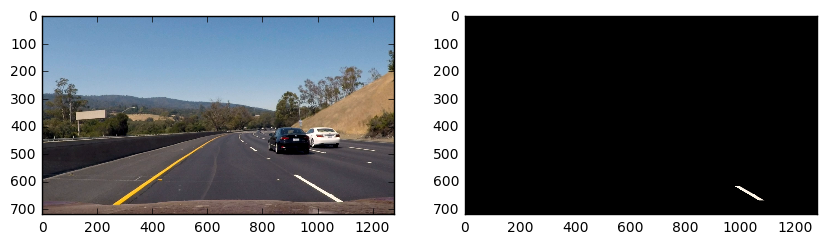

In [21]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
frame_test = clip2.get_frame(0)
coi_w = manual_select(frame_test, 'W')
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(frame_test)
plt.subplot(1,2,2)
plt.imshow(coi_w)

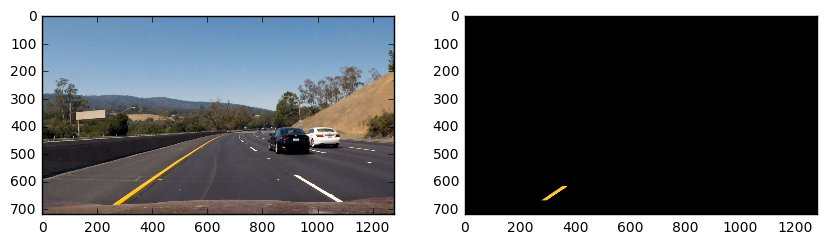

In [22]:
coi_y = manual_select(frame_test, 'Y')
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(frame_test)
plt.subplot(1,2,2)
plt.imshow(coi_y)

---
__Plot the hsv hist for selecting__

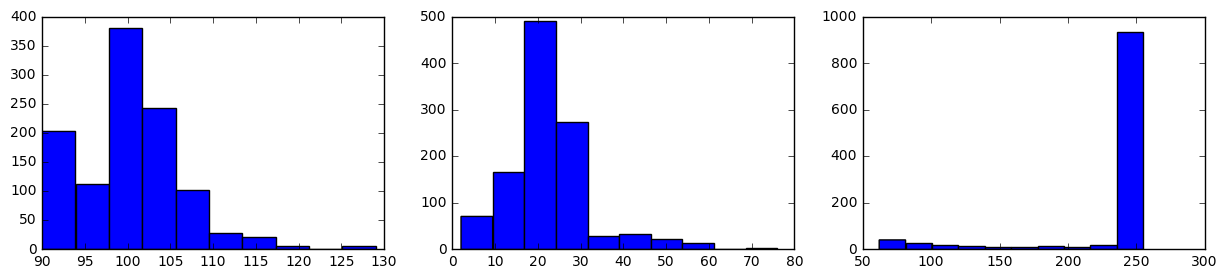

In [23]:
hsv_hist(coi_w)

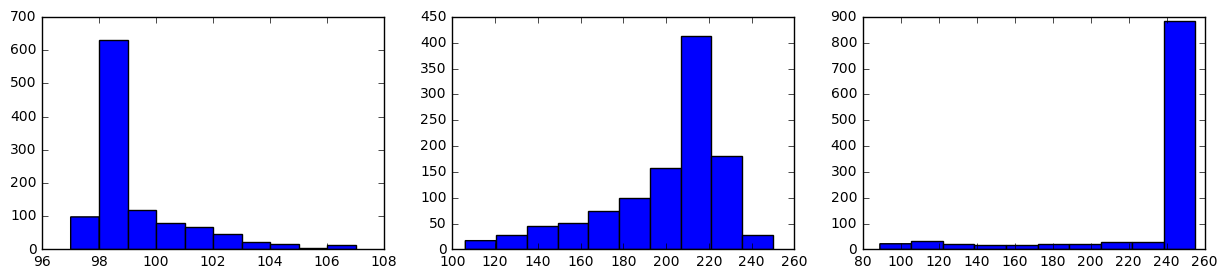

In [24]:
hsv_hist(coi_y)

---
__According to the hsv histogram, manually picked lower and upper lane line color__

In [25]:
low_white  = np.array([ 80,   0, 185])
up_white   = np.array([200,  30, 255])

low_yellow = np.array([ 80, 140, 100])
up_yellow  = np.array([120, 270, 260])
def color_of_interest(img_ref, img_mask = None, colors = [[low_yellow, up_yellow], [low_white, up_white]]):
    ''' this function is used for selecting white and yellow'''
    hsv = cv2.cvtColor(img_ref, cv2.COLOR_BGR2HSV)
    mask = np.zeros_like(img_ref[:,:,0])
    for color in colors:
        mask += cv2.inRange(hsv, color[0], color[1])
        
    img = img_mask if img_mask is not None else img_ref # cover the original or not
    masked_image = cv2.bitwise_and(img, img, mask = mask)
    return masked_image

---
__Then test the color selection on the video__

In [26]:
challenge_clip = clip2.fl_image(color_of_interest)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:12<00:00, 20.39it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 32.5 s, sys: 1.08 s, total: 33.6 s
Wall time: 12.9 s


In [27]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

### Step 2
With color selection, It seems the pipeline has more clue to detect the lane lines.
In the next few cells, I modify the lane detection algorithms.

---
Modifications Include:
1. The class can now recognize the size of the video
2. Color of interest is introduced to the pipeline
3. Use 2-frame cache

---
The Final Pipeline:
```
coi -> blur -> Canny -> bitwise_or the cached 2 frames -> roi -> Hough -> result 
```

In [28]:
im_wb = 90  # pixels away the vertical half
im_hb = 90  # pixels below the horizontal half
btm = 80

class lane_sensor:
    
    def __init__(self):
        self.im_w = None
        self.im_h = None
        self.vertices = None
        self.pre_x = None
        self.cache1 = None
        self.cache2 = None
        
        
    def make(self, img): 
        '''use this to detect the shape of a video'''
        self.im_w = img.shape[1]
        self.im_h = img.shape[0]
        self.vertices = np.array([[(self.im_w//2 - im_wb, self.im_h//2 + im_hb),
                                   (self.im_w//2 + im_wb, self.im_h//2 + im_hb),
                                   (self.im_w - btm, self.im_h),
                                   (btm, self.im_h)]])
        
    def draw_lines(self, img, lines, color=[255, 0, 0], thickness=7):
        '''a modified version of lines drawing'''
        mid = self.im_w/2
        max_len_l = [0, 0]
        max_len_r = [0, 0]
        max_line_l = [[0,0,0,0],[0,0,0,0]]
        max_line_r = [[0,0,0,0],[0,0,0,0]]

        # find top two lines according to length of both sides
        for line in lines:
            for x1, y1, x2, y2 in line:
                if y1-y2 == 0:
                    continue
                lth = (x1-x2)**2 + (y1-y2)**2
                if min(x1, x2) < mid:
                    if max_len_l[0] < lth:
                        max_len_l[0] = lth
                        max_line_l[0] = line[0]
                    elif max_len_l[1] < lth:
                        max_len_l[1] = lth
                        max_line_l[1] = line[0]
                elif max(x1, x2) > mid:
                    if max_len_r[0] < lth:
                        max_len_r[0] = lth
                        max_line_r[0] = line[0]
                    elif max_len_r[1] < lth:
                        max_len_r[1] = lth
                        max_line_r[1] = line[0]
        h_sep = self.im_h//2 + im_hb
        # extend the two lines and take avg    
        
        ## extend and avg 
        ext_x1_l = (ext_x(max_line_l[0], self.im_h)+ext_x(max_line_l[1], self.im_h))//2
        ext_x2_l = (ext_x(max_line_l[0], h_sep)+ext_x(max_line_l[1], h_sep))//2
        ext_x1_r = (ext_x(max_line_r[0], self.im_h)+ext_x(max_line_r[1], self.im_h))//2
        ext_x2_r = (ext_x(max_line_r[0], h_sep)+ext_x(max_line_r[1], h_sep))//2

        pre_xx = self.pre_x if self.pre_x is not None else [ext_x1_l, ext_x2_l, ext_x1_r, ext_x2_r]
        cv2.line(img, ((ext_x1_l + pre_xx[0])//2, self.im_h), ((ext_x2_l + pre_xx[1])//2, h_sep), color, thickness)
        cv2.line(img, ((ext_x1_r + pre_xx[2])//2, self.im_h), ((ext_x2_r + pre_xx[3])//2, h_sep), color, thickness)
        
        self.pre_x = [ext_x1_l, ext_x2_l, ext_x1_r, ext_x2_r]
        #cv2.line(img, (ext_x1_l, self.im_h), (ext_x2_l, h_sep), color, thickness)
        #cv2.line(img, (ext_x1_r, self.im_h), (ext_x2_r, h_sep), color, thickness)
    
    def hough_lines(self, img, rho, theta, threshold, min_line_len, max_line_gap):
        lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
        line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
        self.draw_lines(line_img, lines)
        return line_img

    def process_image(self, image):
        if self.vertices is None:
            self.make(image)
        coi = color_of_interest(image)
            
        noise = gaussian_blur(coi, 9)  
        edges = canny(noise, 60, 100)
        e = edges
        if self.cache1 != None:
            edges = cv2.bitwise_or(edges, self.cache1)
            if self.cache2 != None:
                edges = cv2.bitwise_or(edges, self.cache2)          
            self.cache2 = self.cache1 
        self.cache1 = e
            
        roi = region_of_interest(edges, [self.vertices])
        lines = self.hough_lines(roi,1,np.pi/180,20,20,10) 
        result = weighted_img(lines, image)

        return result



In [ ]:
ls = lane_sensor()
challenge_clip = clip2.fl_image(ls.process_image)
challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


 83%|████████▎ | 209/251 [00:33<00:08,  5.20it/s]

In [26]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))